# Raw Data Thresholding Exploration
## A slice at z=0 for reference

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pickle
import sys
sys.path.insert(0,'../code/functions/')
import connectLib as cLib
import plosLib as pLib
import mouseVis as mv 
import tiffIO as tIO

data0 = tIO.unzipChannels(tIO.loadTiff('../data/SEP-GluA1-KI_tp1.tif'))[0][5:10]

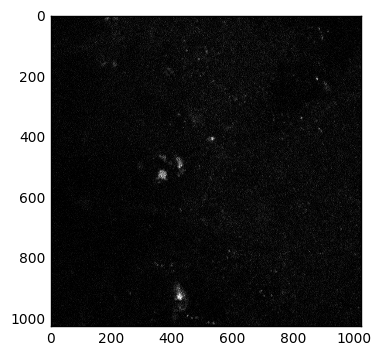

In [15]:
plt.imshow(data0[0], cmap='gray')
plt.show()

## Our Previous Method: Otsu's Binarization 
With our previous pipeline, we found that we were only yielding 2 clusters in total accross the entire volume. After some investigation, we found that the error was occuring in our thresholding method for the raw data. We were using Otsu's Binarization, and it was grouping a large portion of our data together into a couple massive clusters. This was an issue. 

This is what resulted from Otsu's Binarization.

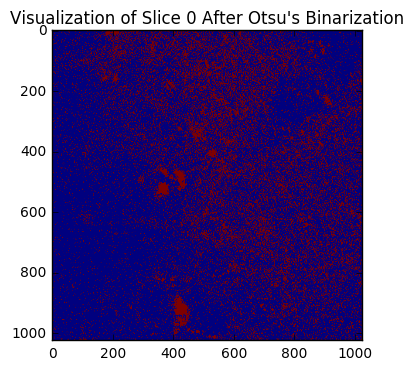

Analysis of Otsu-Thresholded Clusters
	number of clusters: 33210
	average volume: 157.870520927


In [49]:
data0OtsuThresh = cLib.otsuVox(data0)
plt.imshow(data0OtsuThresh[0])
plt.title("Visualization of Slice 0 After Otsu's Binarization")
plt.show()
clusters = cLib.connectedComponents(data0OtsuThresh)
volumeList = np.zeros((len(clusters)))
print 'Analysis of Otsu-Thresholded Clusters'
for cluster in range(len(clusters)):
     volumeList[cluster] = clusters[cluster].getVolume()

print '\tnumber of clusters: ' + str(len(volumeList))
print '\taverage volume: ' + str(np.average(volumeList))

This result initially seemed reasonable. But, as a sanity check, we naively thresholded these clusters by volume (throwing out all clusters with volume above 200) to understand how clustering was occuring.

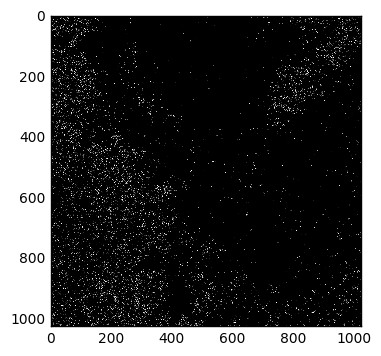

Analysis of Naively Thresholded Clusters Using Otsu's Binarization
	number of clusters below 200-volume: 33177
	average volume of clusters below 200-volume: 3.96380022305


In [71]:
naiveThreshClusters = cLib.thresholdByVolumeNaive(clusters, limit=200)
displayIm = np.zeros_like(data0)
clusterMembersList =[]
for cluster in range(len(naiveThreshClusters)):
    clusterMembersList.extend(naiveThreshClusters[cluster].members)

    
for index in range(len(clusterMembersList)):
    x, y, z = clusterMembersList[index]
    displayIm[x][y][z] = 100
    
plt.imshow(displayIm[0], cmap = 'gray')
plt.show()



volumeList = np.zeros((len(naiveThreshClusters)))
print "Analysis of Naively Thresholded Clusters Using Otsu's Binarization"
for cluster in range(len(naiveThreshClusters)):
     volumeList[cluster] = naiveThreshClusters[cluster].getVolume()

print '\tnumber of clusters below 200-volume: ' + str(len(volumeList))
print '\taverage volume of clusters below 200-volume: ' + str(np.average(volumeList))

What we found was that, after thresholding by volume naively, there were very few clusters in the most concentrated areas. Further investigation showed that, before naive thresholding, there were 33210 clusters. After naive thresholding, there were 33177. This means that using Otsu's + Connected Components yielded 33 clusters that were massive. Most notably, the majority of the most concentrated strip (where most synapses are likely to be found) was grouped into a couple big clusters. Thus, we needed to find a more appropiate method for thresholding the raw data so we could also evaluate the clusters along that concentrated strip.

## Adaptive Thresholding 
We first attempted adaptive thresholding, as it allows localized thresholding - this is good because average intensity greatly varies accross the z axis. Adaptive thresholding works by calculating the mean of a blockSize x blockSize x blockSize neighborhood, subtracting a C-value from such mean, and thresholding all voxels in the neighborhood below that value. This seemed like it would work. However, we found that the results weren't as promising as we'd hoped. Such results are shown below.

In [22]:
from connectLib import adaptiveThreshold

blocksize: 11


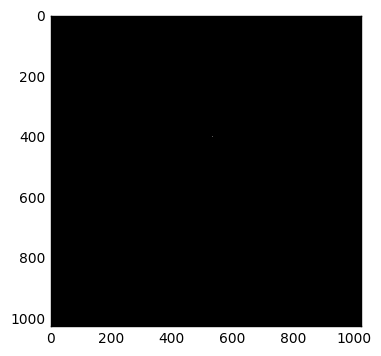

	number of clusters below 200-volume: 6
	average volume of clusters below 200-volume: 1.0
blocksize: 21


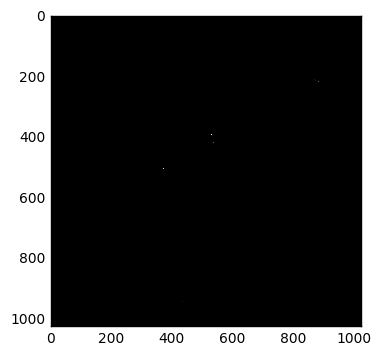

	number of clusters below 200-volume: 54
	average volume of clusters below 200-volume: 1.5
blocksize: 31


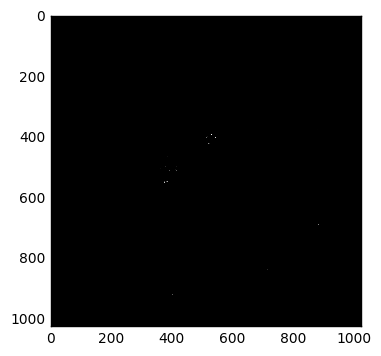

	number of clusters below 200-volume: 112
	average volume of clusters below 200-volume: 2.1875
blocksize: 41


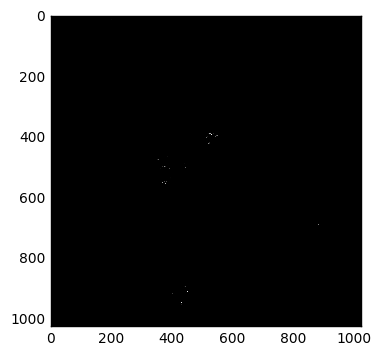

	number of clusters below 200-volume: 169
	average volume of clusters below 200-volume: 2.43195266272
blocksize: 51


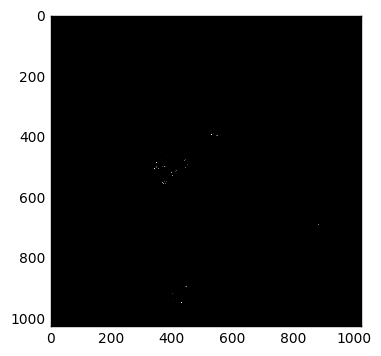

	number of clusters below 200-volume: 215
	average volume of clusters below 200-volume: 2.47441860465
blocksize: 61


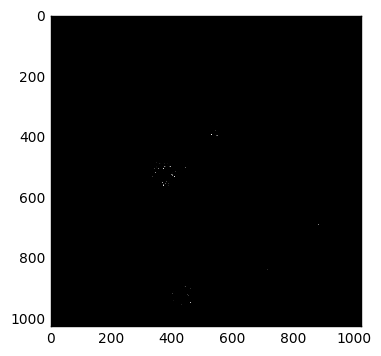

	number of clusters below 200-volume: 280
	average volume of clusters below 200-volume: 2.56071428571
blocksize: 71


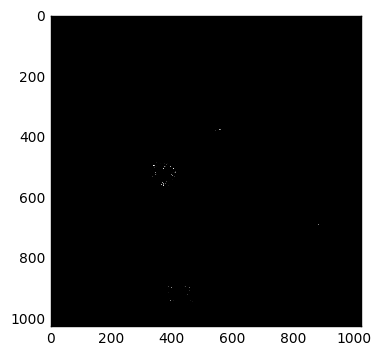

	number of clusters below 200-volume: 305
	average volume of clusters below 200-volume: 2.5737704918
blocksize: 81


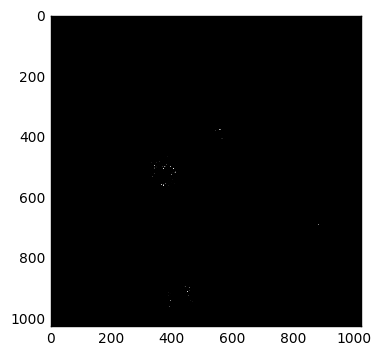

	number of clusters below 200-volume: 295
	average volume of clusters below 200-volume: 2.52203389831
blocksize: 91


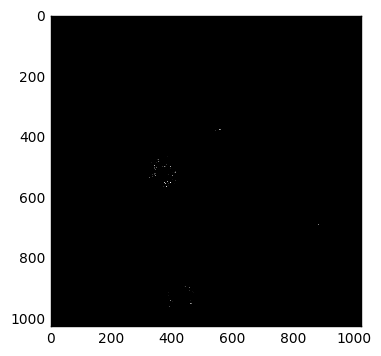

	number of clusters below 200-volume: 292
	average volume of clusters below 200-volume: 2.89726027397


In [73]:
for i in range(9):
    print 'blocksize: ' + str(10*(i + 1) + 1)
    data0AdaptiveThresh = adaptiveThreshold(data0, 10*(i + 1) + 1, 5)
    clusters = cLib.connectedComponents(data0AdaptiveThresh)
    naiveThreshClusters = cLib.thresholdByVolumeNaive(clusters, limit=200)
    displayIm = np.zeros_like(data0)
    clusterMembersList =[]
    for cluster in range(len(naiveThreshClusters)):
        clusterMembersList.extend(naiveThreshClusters[cluster].members)


    for index in range(len(clusterMembersList)):
        x, y, z = clusterMembersList[index]
        displayIm[x][y][z] = 100

    plt.imshow(displayIm[0], cmap = 'gray')
    plt.show()



    volumeList = np.zeros((len(naiveThreshClusters)))
    for cluster in range(len(naiveThreshClusters)):
         volumeList[cluster] = naiveThreshClusters[cluster].getVolume()

    print '\tnumber of clusters below 200-volume: ' + str(len(volumeList))
    print '\taverage volume of clusters below 200-volume: ' + str(np.average(volumeList))

We found that a blocksize of 81 optimized the number of clusters below 200-volume. Thus, we also tried varying the subtracted value (called "C") from the voxels in each window.

C-value: 0


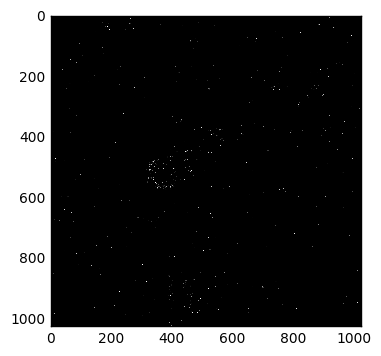

	number of clusters below 200-volume: 2300
	average volume of clusters below 200-volume: 2.28217391304
C-value: 1


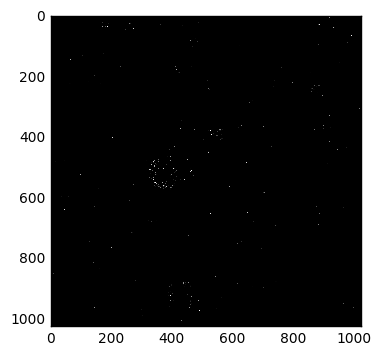

	number of clusters below 200-volume: 1360
	average volume of clusters below 200-volume: 2.37426470588
C-value: 2


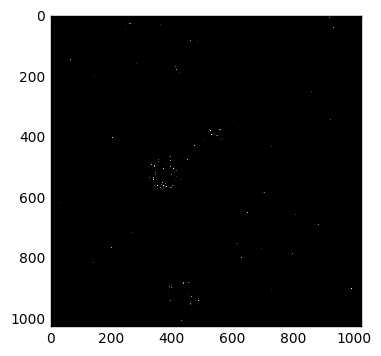

	number of clusters below 200-volume: 793
	average volume of clusters below 200-volume: 2.52837326608
C-value: 3


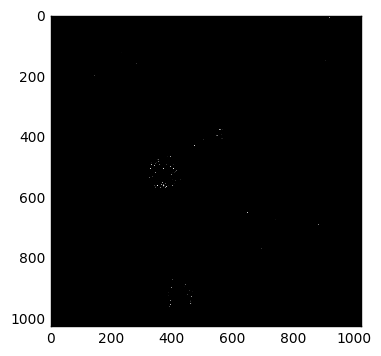

	number of clusters below 200-volume: 519
	average volume of clusters below 200-volume: 2.49132947977


In [74]:
for i in range(4):
    print 'C-value: ' + str(i)
    data0AdaptiveThresh = adaptiveThreshold(data0, 81, i)
    clusters = cLib.connectedComponents(data0AdaptiveThresh)
    naiveThreshClusters = cLib.thresholdByVolumeNaive(clusters, limit=200)
    displayIm = np.zeros_like(data0)
    clusterMembersList =[]
    for cluster in range(len(naiveThreshClusters)):
        clusterMembersList.extend(naiveThreshClusters[cluster].members)


    for index in range(len(clusterMembersList)):
        x, y, z = clusterMembersList[index]
        displayIm[x][y][z] = 100

    plt.imshow(displayIm[0], cmap = 'gray')
    plt.show()

    volumeList = np.zeros((len(naiveThreshClusters)))
    for cluster in range(len(naiveThreshClusters)):
         volumeList[cluster] = naiveThreshClusters[cluster].getVolume()

    print '\tnumber of clusters below 200-volume: ' + str(len(volumeList))
    print '\taverage volume of clusters below 200-volume: ' + str(np.average(volumeList))

Thus, we found that the best combination of hyperparameters was blockSize = 81, C=0. But even with these hyperparameters, the number of clusters below 200-volume was too low (2300 vs expected ~tens of thousands). Thus, we decided to explore binary thresholding. 

## Binary Thresholding 
The initial concern with using binary thresholding is that the average intensity of the base slices (around z=0) is 4x that of the top slices (around z=280). An implimentation of binary thresholding that uses a single value for the entire volume would either throw out almost the entire top half of the 3D image (if we used a very restrictive, high value for the hyperparameter) or wouldn't threshold enough of the entire bottom half of the 3D image (if we used a low value for the hyperparameter) and would result in most of the bottom half being grouped together into one cluster.

To fix this issue, we decided to impliment our own 3-dimensional binary thresholding method that locally thresholds within each slice based off of percentile. Such implimentation is shown below:

In [45]:
def binaryThreshold(img, perc):
    img = (img/256).astype('uint8')
    threshImg = np.zeros_like(img)
    percentile = np.percentile(img, perc)
    for i in range(len(img)):
        threshImg[i] = cv2.threshold(img[i], percentile, 255, cv2.THRESH_BINARY)[1]
    return threshImg

We decided to try out many different hyperparameters for the percentile value to find which one gave the most number of clusters and the average volume closest to ~54. The results are shown below:

percentile: 75


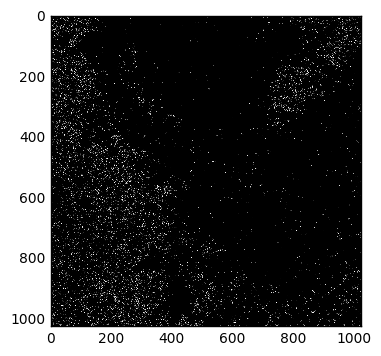

	number of clusters below 200-volume: 33255
	average volume of clusters below 200-volume: 3.96692226733
percentile: 80


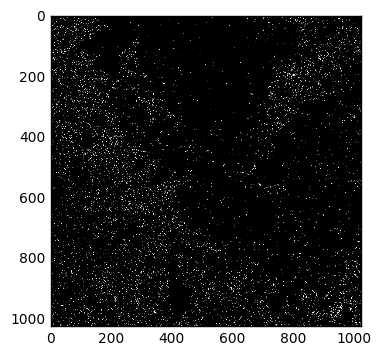

	number of clusters below 200-volume: 42118
	average volume of clusters below 200-volume: 3.61679092075
percentile: 85


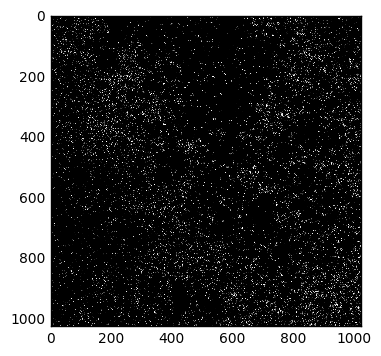

	number of clusters below 200-volume: 53249
	average volume of clusters below 200-volume: 3.83370579729
percentile: 90


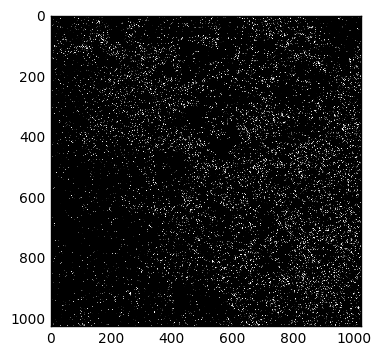

	number of clusters below 200-volume: 59868
	average volume of clusters below 200-volume: 3.9442774103
percentile: 95


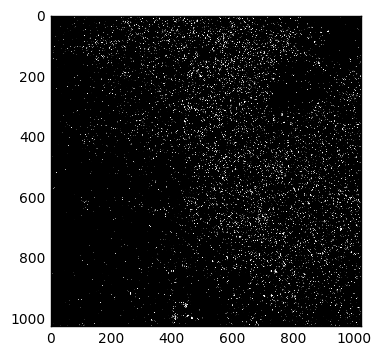

	number of clusters below 200-volume: 52305
	average volume of clusters below 200-volume: 3.35535799637


In [10]:
for i in range(5):
    print 'percentile: ' + str(75 + 5*i)
    data0AdaptiveThresh = binaryThreshold(data0, 75 + 5*i)
    clusters = cLib.connectedComponents(data0AdaptiveThresh)

    naiveThreshClusters = cLib.thresholdByVolumeNaive(clusters, limit=200)
    displayIm = np.zeros_like(data0)
    clusterMembersList =[]
    for cluster in range(len(naiveThreshClusters)):
        clusterMembersList.extend(naiveThreshClusters[cluster].members)


    for index in range(len(clusterMembersList)):
        x, y, z = clusterMembersList[index]
        displayIm[x][y][z] = 100

    plt.imshow(displayIm[0], cmap = 'gray')
    plt.show()



    volumeList = np.zeros((len(naiveThreshClusters)))
    for cluster in range(len(naiveThreshClusters)):
         volumeList[cluster] = naiveThreshClusters[cluster].getVolume()

    print '\tnumber of clusters below 200-volume: ' + str(len(volumeList))
    print '\taverage volume of clusters below 200-volume: ' + str(np.average(volumeList))

### Analysis of Binary Thresholding Results
Our implimentation of binary thresholding at the 90th percentile yielded the most desirable results. It produced the most clusters below 200-volume, contained a significant amount of clusters along the concentrated strip, and yielded clusters with relatively high volume.

Further investigation with percentiles neighboring 90 showed that the 90th percentile yielded the best results.

percentile: 89


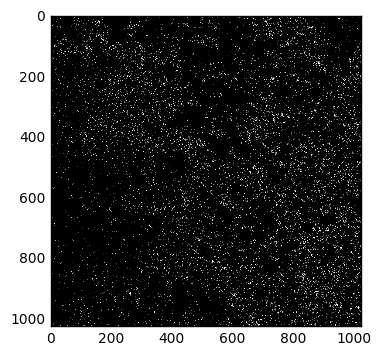

	number of clusters below 200-volume: 58333
	average volume of clusters below 200-volume: 3.95686832496
percentile: 90


In [ ]:
for i in range(3):
    percentile = 89 + i
    print 'percentile: ' + str(percentile)
    data0AdaptiveThresh = binaryThreshold(data0, percentile)
    clusters = cLib.connectedComponents(data0AdaptiveThresh)

    naiveThreshClusters = cLib.thresholdByVolumeNaive(clusters, limit=200)
    displayIm = np.zeros_like(data0)
    clusterMembersList =[]
    for cluster in range(len(naiveThreshClusters)):
        clusterMembersList.extend(naiveThreshClusters[cluster].members)


    for index in range(len(clusterMembersList)):
        x, y, z = clusterMembersList[index]
        displayIm[x][y][z] = 100

    plt.imshow(displayIm[0], cmap = 'gray')
    plt.show()



    volumeList = np.zeros((len(naiveThreshClusters)))
    for cluster in range(len(naiveThreshClusters)):
         volumeList[cluster] = naiveThreshClusters[cluster].getVolume()

    print '\tnumber of clusters below 200-volume: ' + str(len(volumeList))
    print '\taverage volume of clusters below 200-volume: ' + str(np.average(volumeList))

## Conclusion 
With locally-binarized thresholding at the 90th percentile yielding the best results, we decided to impliment this method in our pipeline. It is currently used to threshold the raw data. 

## Future Plans 
We hope to create an Algorithms.md to fully explain and understand our local, percentile-based binary thresholding method. 